In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import datetime

In [3]:
data = pd.read_csv('dataframe/champions.csv')

In [4]:
data.head()

,idPartido,Temporada,Ronda,Local,Visitante,Evento,GolesLocal,GolesVisitante,VictoriaLocal,Empate,...,1_MediaJugadores,%_2_G_Temporada,%_2_G_Temporada_L,%_2_E_Temporada_L,%_2_P_Temporada_L,2_Media_G,2_Media_G_Local,2_Media_Goles_PP,2_ValorJugadores,2_MediaJugadores
0,126,2022-01-01,Group stage,235,11,Stadion Maksimir,1,0,1,0,...,18.743616,55.56,60.00,20.00,20.00,0.56,0.60,1.33,685.188968,26.353422
1,127,2022-01-01,Group stage,14,153,Signal Iduna Park,3,0,1,0,...,19.853461,0.00,0.00,100.00,0.00,0.00,0.00,0.20,356.128703,14.245148
2,128,2022-01-01,Group stage,16,1,Celtic Park,0,3,0,0,...,18.490575,63.64,83.33,16.67,0.00,0.64,0.83,2.09,796.271706,36.194168
3,129,2022-01-01,Group stage,10,298,Estádio do Sport Lisboa e Benfica,2,0,1,0,...,28.153728,20.00,33.33,0.00,66.67,0.20,0.33,1.40,382.737487,19.136874
4,130,2022-01-01,Group stage,184,2,Red Bull Arena,1,1,0,1,...,19.353798,45.45,66.67,0.00,33.33,0.45,0.67,1.27,749.233912,32.575387


In [5]:
data['Temporada'] = pd.to_datetime(data['Temporada'])
data = data.sort_values(by='Temporada')  # Ordenar por temporada
data.set_index('Temporada', inplace=True)  # Establecer la temporada como índice


### ARIMA

In [6]:
def plot_data(data, equipo):
    equipo_local = data[data['Local'] == equipo].groupby('Temporada')['GolesLocal'].sum()
    equipo_visitante = data[data['Visitante'] == equipo].groupby('Temporada')['GolesVisitante'].sum()

    # Crear una figura y un eje
    fig, ax = plt.subplots(figsize=(12, 6))

    # Graficar goles como local
    ax.plot(equipo_local.index, equipo_local.values, marker='o', linestyle='-', color='blue', label='Goles como Local')

    # Graficar goles como visitante
    ax.plot(equipo_visitante.index, equipo_visitante.values, marker='x', linestyle='--', color='green', label='Goles como Visitante')

    # Configuración del gráfico
    ax.set_xlabel('Temporada')
    ax.set_ylabel('Goles')
    ax.set_title(f'Goles por Temporada - Equipo Real Madrid')
    ax.legend()
    ax.grid(True)

    plt.show()

def arima_model(data, equipo, order):
    equipo_data = data[(data['Local'] == equipo) | (data['Visitante'] == equipo)]
    model = ARIMA(equipo_data['GolesLocal'], order=order)
    result = model.fit()
    return result

def forecast(result, steps):
    forecast = result.forecast(steps=steps)
    print(forecast)
    return forecast


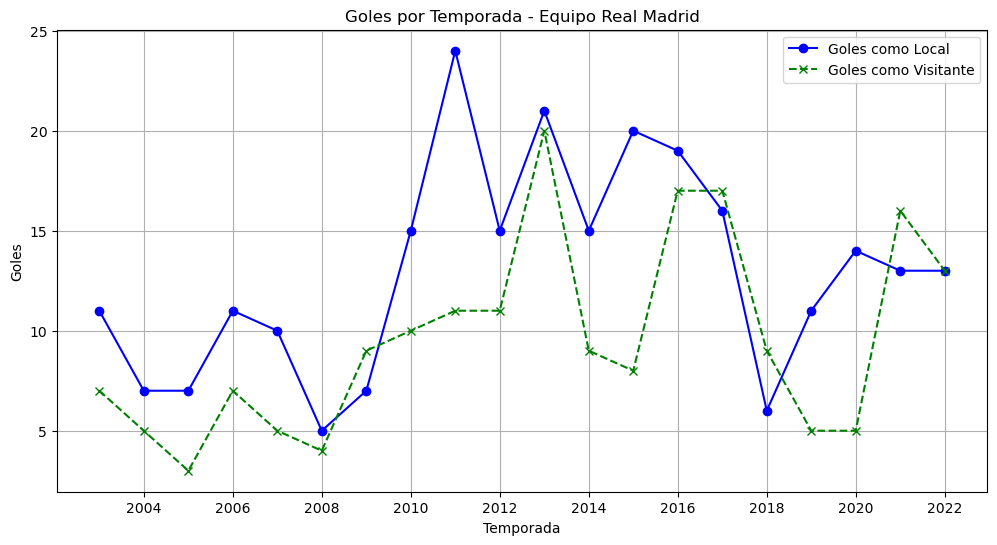

211    1.841234
212    1.820119
213    1.819978
214    1.819977
215    1.819977
Name: predicted_mean, dtype: float64


/Users/carlotasanchezgonzalez/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/carlotasanchezgonzalez/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/carlotasanchezgonzalez/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/carlotasanchezgonzalez/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Predicti

In [7]:
# Visualizar la serie temporal para el equipo 1
plot_data(data, equipo=1)

# Ajustar un modelo ARIMA para el equipo 1
modelo_arima = arima_model(data, equipo=1, order=(1,1,1))

# Realizar un pronóstico para el equipo 1
pronostico_arima = forecast(modelo_arima, steps=5)


### SARIMA

In [8]:
def sarima_model(data, equipo, order, seasonal_order):
    equipo_data = data[(data['Local'] == equipo) | (data['Visitante'] == equipo)]
    model = SARIMAX(equipo_data['GolesLocal'], order=order, seasonal_order=seasonal_order)
    result = model.fit()
    return result

modelo_sarima = sarima_model(data, equipo=1, order=(1,1,1), seasonal_order=(1,1,1,12))
pronostico_sarima = forecast(modelo_sarima, steps=5)

pronostico_sarima


/Users/carlotasanchezgonzalez/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/carlotasanchezgonzalez/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.94239D+00    |proj g|=  1.68174D-01

At iterate    5    f=  1.80186D+00    |proj g|=  7.05850D-02

At iterate   10    f=  1.78288D+00    |proj g|=  1.26626D-02

At iterate   15    f=  1.78110D+00    |proj g|=  2.14370D-03

At iterate   20    f=  1.78086D+00    |proj g|=  2.67330D-04

At iterate   25    f=  1.78084D+00    |proj g|=  1.45526D-04

At iterate   30    f=  1.78084D+00    |proj g|=  2.75087D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/carlotasanchezgonzalez/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/carlotasanchezgonzalez/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


211    1.456122
212    1.601293
213    1.274471
214    1.370121
215    2.525628
Name: predicted_mean, dtype: float64

In [9]:
modelo_arima.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             GolesLocal   No. Observations:                  211
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -379.537
Date:                Wed, 15 May 2024   AIC                            765.074
Time:                        09:43:17   BIC                            775.115
Sample:                             0   HQIC                           769.133
                                - 211                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0067      0.066      0.102      0.919      -0.122       0.136
ma.L1         -0.9999      2.435     -0.411      0.681      -5.772       3.772
sigma2         2.1196      5.166      0.410      0.682      -8.006      12.246
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                28.82
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.97   Skew:                             0.81
Prob(H) (two-sided):                  0.90   Kurtosis:                         3.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""